- https://learn.deeplearning.ai/courses/pretraining-llms/lesson/xg5n5/why-pre-training

> AI is the new electricity and will transform and improve nearly all areas of human lives. [Andrew Ng](https://www.andrewng.org/) 가장 마지막으로 갈 것.

# Pre-training LLM

- sung kim and lucy park, Pre-training LLM, deeplearning.ai

Training a large language model (LLM) from scratch is computationally expensive and time-consuming. Pre-training a large language model on a large corpus of text data and then fine-tuning it on a smaller dataset for a specific task is a common practice in natural language processing (NLP). In this article, we will discuss the benefits of pre-training LLMs and how to pre-train them.

## Purpose of pre-training LLM

Some are buiding models for tasks in specific domains like legal, healthcare and e-commmerse. other in specific languages like Chinese, Arabic and Korean. Furthermore, new training methods are making it more efficient pre-training possible like depth upscaling, which uses two or more sets of exising models to build larger models. 

In this course, you'll learn all of the necessary steps to pre-train a model from scratch, from gathering and preparing train data, to configuring a model and training it.


In [1]:
#| echo:false

# Ignore insignificant warnings (ex: deprecations)
import warnings
# Set a seed for reproducibility
import torch

warnings.filterwarnings("ignore")

def fix_torch_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_torch_seed()


## Load a general pretrained model

This course will work with small models that fit within the memory of the learning platform. TinySolar-248m-4k is a small decoder-only model with 248M parameters (similar in scale to GPT2) and a 4096 token context window. You can find the model on the Hugging Face model library at [this link](https://huggingface.co/upstage/TinySolar-248m-4k).

You'll load the model in three steps:
1. Specify the path to the model in the Hugging Face model library
2. Load the model using `AutoModelforCausalLM` in the `transformers` library
3. Load the tokenizer for the model from the same model path

# Lecture 2: Data Preparation

When pre-training a language model, the quality of the data you use is crucial. In this lesson you'll carry out some of the data cleaning steps required to prepare data for pretraining. In the video, Sung mentioned an Upstage tool called **Dataverse** which can help you with data cleaning. You can checkout the features of Dataverse at [this link](https://github.com/UpstageAI/dataverse).

**Sourcing datasets for pretraining**

In this section, you'll see two ways to source data for training:
1. Download an existing dataset from Hugging Face
2. Create a dataset of python scripts sourced from Github

In both cases the result will be a Hugging Face `Dataset` object, part of the `Datasets` library. You can read more about the properties of Datasets and how to work with them on the [Hugging Face website](https://huggingface.co/docs/datasets/en/index).

## Download data from Hugging face

The dataset you download here is a subset of a much larger dataset called **Red Pajama**. The full, 1 trillion token dataset is available on Hugging Face at [this link](https://huggingface.co/datasets/togethercomputer/RedPajama-Data-1T).

In [2]:
import datasets

pretraining_dataset = datasets.load_dataset(
    "upstage/Pretraining_Dataset", split="train"
)
pretraining_dataset = pretraining_dataset.select_columns(["text"])
print(pretraining_dataset)


Dataset({
    features: ['text'],
    num_rows: 60000
})


### Compare pretraining and fine-tuning datasets

In the next cell, you'll download a fine-tuning dataset to contrast with the pretraining dataset you loaded above. You can read more about the Alpaca model and instruction tuning dataset [here](https://crfm.stanford.edu/2023/03/13/alpaca.html). 

In [3]:
instruction_dataset = datasets.load_dataset("c-s-ale/alpaca-gpt4-data", split="train")

i = 0

print(
    "Instruction: "
    + instruction_dataset[i]["instruction"]
    + "\nInput: "
    + instruction_dataset[i]["input"]
    + "\nOutput: "
    + instruction_dataset[i]["output"]
)


Instruction: Give three tips for staying healthy.
Input: 
Output: 1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.

2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.

3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.


Notice how in contrast to the pretraining data, which is just raw text, fine-tuning datasets are structured into question-answer pairs or instruction-response sets that can include additional input context if required. 


Moving forward, you'll only work with the unstructured pretraining dataset.

## Scrape python code from Github

Here, you'll download a selection of python scripts from Github and then prepare them as a Hugging Face `Dataset` object to use in training. 

The same pattern here will work for preparing any text scraped from the web.

In [4]:
# Import some required packages
import os
import requests

# Path to directory to store python scripts
code_dir = "../src/"
urls = [
    "https://raw.githubusercontent.com/TheAlgorithms/Python/master/searches/double_linear_search_recursion.py",
    "https://raw.githubusercontent.com/KosingZhu/tensorflow/master/tensorflow/python/tools/module_util.py",
    "https://raw.githubusercontent.com/EricRemmerswaal/tensorflow/master/tensorflow/python/distribute/distribute_coordinator_context.py",
    "https://raw.githubusercontent.com/computationalartist/tensorflow/master/tensorflow/python/ops/numpy_ops/integration_test/benchmarks/numpy_mlp.py",
    "https://raw.githubusercontent.com/Van-an/tensorflow/master/tensorflow/python/distribute/coordinator/values.py",
    "https://raw.githubusercontent.com/nkgwer/tensorflow/master/tensorflow/lite/tools/visualize.py",
    "https://raw.githubusercontent.com/gitblazer/youtube-dl/master/youtube_dl/version.py",
    "https://raw.githubusercontent.com/Joshua-Barawa/My-Photos/master/venv/lib/python3.8/site-packages/django/contrib/messages/__init__.py",
    "https://raw.githubusercontent.com/PaliC/pytorch/master/test/fx/test_subgraph_rewriter.py",
]
for url in urls:
    response = requests.get(url)
    file_name = os.path.basename(url)
    file_path = os.path.join(code_dir, file_name)

    with open(file_path, "wb") as file:
        file.write(response.content)

files = os.listdir(code_dir)

for file in files:
    print(file)


module_util.py
240628_learn_async.py
double_linear_search_recursion.py
values.py
test_subgraph_rewriter.py
version.py
llama_cpp_script.py
huggingface_test.py
240628_gen_mutants.py
numpy_mlp.py
230413_Python_Tish2Downloader.py
visualize.py
240628_pdb-seq.py
distribute_coordinator_context.py
__init__.py
dotenv.py
finetune_tutorial.py
linear_reg.py
KULLM.py


In [5]:
code_dataset = []

for file in os.listdir(code_dir):
    code_dataset.append({"text": open(os.path.join(code_dir, file), "r").read()})

code_dataset = datasets.Dataset.from_list(code_dataset)

dataset = datasets.concatenate_datasets([pretraining_dataset, code_dataset])
print(dataset)


Dataset({
    features: ['text'],
    num_rows: 60019
})


## Data cleaning

In the cells below, you'll carry out the following cleaning steps:
1. Filter out samples that are too short
2. Remove repetitions within a single text example
3. Remove duplicated documents
4. Quality filter to remove non-English texts

### Remove examples that are too short


In [6]:
dataset.num_rows


60019

In [7]:
import heapq
import re


def paragraph_length_filter(x):
    """Returns False iff a page has too few lines or lines are too short."""
    lines = x["text"].split("\n")
    if len(lines) < 3 or min(heapq.nlargest(3, [len(line) for line in lines])) < 3:
        return False
    return True


dataset = dataset.filter(paragraph_length_filter, load_from_cache_file=False)
dataset.num_rows


Filter:   0%|          | 0/60019 [00:00<?, ? examples/s]

52366

### Remove repeated text within training examples

Here you'll remove text repetitions within each example. 

In [8]:
def find_duplicates(paragraphs):
    """
    Use this function to find the number of repetitions
    in the paragraphs.
    """
    unique_x = set()
    duplicate_chars = 0
    duplicate_elements = 0
    for element in paragraphs:
        if element in unique_x:
            duplicate_chars += len(element)
            duplicate_elements += 1
        else:
            unique_x.add(element)
    return duplicate_elements, duplicate_chars

def paragraph_repetition_filter(x):
    """
    Returns False iff a page has too many repetitions.
    """
    text = x["text"]
    paragraphs = re.compile(r"\n{2,}").split(
        text.strip()
    )  # Split by paragraphs (2 or more newlines)
    paragraphs_duplicates, char_duplicates = find_duplicates(
        paragraphs
    )  # Find number of duplicates in paragraphs
    if paragraphs_duplicates / len(paragraphs) > 0.3:
        return False
    if char_duplicates / len(text) > 0.2:
        return False
    return True

dataset = dataset.filter(paragraph_repetition_filter, load_from_cache_file=False)
dataset.num_rows


Filter:   0%|          | 0/52366 [00:00<?, ? examples/s]

52336

### Deduplication

In this section, you'll remove duplicate examples from the entire dataset (in contrast to the previous step where you were just looking for repeated text in each example.)

In [9]:
def deduplication(ds):
    def dedup_func(x):
        """Use this function to remove duplicate entries"""
        if x["text"] in unique_text:
            return False
        else:
            unique_text.add(x["text"])
            return True

    unique_text = set()

    ds = ds.filter(dedup_func, load_from_cache_file=False, num_proc=1)
    return ds


dataset = deduplication(dataset)
dataset.num_rows


Filter:   0%|          | 0/52336 [00:00<?, ? examples/s]

43607

### Quality filter - Language

Here you'll remove any text examples that are in a language other than English. The code here uses a language detection model called fastText. You can read about fastText [here](https://fasttext.cc/).

In [10]:
import urllib
from fasttext.FastText import _FastText


def english_language_filter(ds):
    # load language detection model
    model = _FastText("../models/L2_language_model.bin")

    def is_english(x):
        # Predict language of the text and probability
        language, score = model.predict(x["text"].replace("\n", ""))

        # Check if the language is English and the score is above 0.4
        language = language[0].split("__")[2]
        return (
            score > 0.4 and language == "en"
        )  # change code here if building a model in another language

    ds = ds.filter(is_english, load_from_cache_file=False, num_proc=1)
    return ds


dataset = english_language_filter(dataset)
dataset.num_rows


Parameter 'function'=<function english_language_filter.<locals>.is_english at 0x7d5067fdf880> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Filter:   0%|          | 0/43607 [00:00<?, ? examples/s]

40476

## Save the dataset to disk

Read more about the parquet data format [here](https://parquet.apache.org/).

In [11]:
file_path = "../data/output/preprocessed_dataset.parquet"
dataset.to_parquet(file_path)


Creating parquet from Arrow format:   0%|          | 0/41 [00:00<?, ?ba/s]

197102794

In [12]:
dataset


Dataset({
    features: ['text'],
    num_rows: 40476
})

Now that you have cleaned your datasets, you need to prepare it for training. In this section, you'll learn how to packages your training data so that it can be used in HugginfFace



# Lesson 3: Data Packaging

Data packaging tokeninzing + packing

Tokenizing breaking each text into smaller, meaningful units, which are callked token. Packing tokens into the maximum sequence length to improve training efficiency.

## 1. Tokenizing and creating input_ids

Start by loading the dataset from the previous lesson:


In [13]:
import datasets

dataset = datasets.load_dataset(
    "parquet", data_files="../data/output/preprocessed_dataset.parquet", split="train"
)
print(dataset)


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 40476
})


Use the `shard` method of the Hugging Face `Dataset` object to split the dataset into 10 smaller pieces, or *shards* (think shards of broken glass). You can read more about sharding at [this link](https://huggingface.co/docs/datasets/en/process#shard).

In [14]:
dataset = dataset.shard(num_shards=10, index=0)
print(dataset)


Dataset({
    features: ['text'],
    num_rows: 4048
})


Load the tokenizer and try it out:

In [15]:
from transformers import AutoTokenizer

model_path_or_name = "upstage/SOLAR-10.7B-v1.0"
tokenizer = AutoTokenizer.from_pretrained(
    model_path_or_name,
    use_fast=False # Note: in this case, long text samples sometimes tend to hang, so we disable fast tokenization. Instead use the map function and the datasets library for parallel processing.
    )
tokenizer.tokenize("I'm a short sentence")

# Create a helper function:
def tokenization(example):
    # Tokenize
    tokens = tokenizer.tokenize(example["text"])

    # Convert tokens to ids
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Add <bos>, <eos> tokens to the front and back of tokens_ids
    # bos: begin of sequence, eos: end of sequence
    token_ids = [tokenizer.bos_token_id] + token_ids + [tokenizer.eos_token_id]
    example["input_ids"] = token_ids

    # We will be using this column to count the total number of tokens
    # in the final dataset
    example["num_tokens"] = len(token_ids)
    return example


Tokenize all the examples in the pretraining dataset:

In [16]:
dataset = dataset.map(tokenization, load_from_cache_file=False)
print(dataset)


Map:   0%|          | 0/4048 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'input_ids', 'num_tokens'],
    num_rows: 4048
})


In [17]:
sample = dataset[3]

print("text", sample["text"][:30])  #
print("\ninput_ids", sample["input_ids"][:30])
print("\nnum_tokens", sample["num_tokens"])


text The Colorado Climate Center pr

input_ids [1, 415, 15837, 1366, 3314, 6064, 5312, 430, 19102, 304, 1178, 356, 281, 3928, 28725, 9735, 28713, 28725, 264, 1052, 14455, 4623, 28725, 9390, 1452, 274, 28725, 17268, 28713, 28725]

num_tokens 549


Check the total number of tokens in the dataset:

In [18]:
import numpy as np

np.sum(dataset["num_tokens"])


5113663

## 2. Packing the data

![Packing data for training](./data_packing.png)

Concatenate input_ids for all examples into a single list:

In [19]:
input_ids = np.concatenate(dataset["input_ids"])
print(len(input_ids))
max_seq_length = 32
total_length = len(input_ids) - len(input_ids) % max_seq_length
print(total_length)


5113663
5113632


Discard extra tokens from end of the list so number of tokens is exactly divisible by `max_seq_length`:

In [20]:
input_ids = input_ids[:total_length]
print(input_ids.shape)
input_ids_reshaped = input_ids.reshape(-1, max_seq_length).astype(np.int32)
print(input_ids_reshaped.shape)
print(type(input_ids_reshaped))


(5113632,)
(159801, 32)
<class 'numpy.ndarray'>


Convert to Hugging Face dataset:

In [21]:
input_ids_list = input_ids_reshaped.tolist()
packaged_pretrain_dataset = datasets.Dataset.from_dict({"input_ids": input_ids_list})
print(packaged_pretrain_dataset)


Dataset({
    features: ['input_ids'],
    num_rows: 159801
})


## 3. Save the packed dataset to disk

In [22]:
packaged_pretrain_dataset.to_parquet("../data/output/packaged_pretrain_dataset.parquet")


Creating parquet from Arrow format:   0%|          | 0/160 [00:00<?, ?ba/s]

21093732

In [23]:
packaged_pretrain_dataset


Dataset({
    features: ['input_ids'],
    num_rows: 159801
})

In [24]:
print(packaged_pretrain_dataset[0]["input_ids"][0:10])


[1, 560, 28705, 28740, 28787, 28774, 28770, 1054, 14886, 23452]


# Lesson 4: Preparing your model for training

## 1. Model configuration

You'll configure models based on Meta's Llama family of models. The transformers library has several tools for working with these models, which you can read about [here](https://huggingface.co/docs/transformers/main/en/model_doc/llama).

Start by creating a `LlamaConfig` object to configure the architecture of the model:

In [25]:
from transformers import LlamaConfig
from transformers import LlamaForCausalLM

def print_nparams(model):
    """Calculate the total number of model parameters"""
    nparams = sum(p.numel() for p in model.parameters())
    print(f"The total number of parameters is: {nparams}")

config = LlamaConfig()
print(config)

# Next, update parameters to change the model architecture:
config.num_hidden_layers = 12  # reduced from 32 to 12
config.hidden_size = 1024  # reduced 1/4 from 4096 to 1024
config.intermediate_size = (
    4096  # reduced 1/3 from 11008 to 4096 (dimension of MLP representations)
)
config.num_key_value_heads = (
    8  # reduced 1/4 from 32 to 8 (defaults to num_attention_heads=32)
)
config.torch_dtype = "bfloat16"  # for half-precision training
config.use_cache = False  # `True` is incompatible w/ gradient checkpointing
print(config)


LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.37.2",
  "use_cache": true,
  "vocab_size": 32000
}

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 12,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": n

## 2. Weight initialization

In the next sections, you'll explore four different ways to initialize the weights of a model for training:
1. Random weight initialization
2. Using an existing model for continued pre-training
3. Downscaling an existing model
4. Upscaling an existing model

In [26]:
config.num_hidden_layers = 12      # reduced from 32 to 12
config.hidden_size = 1024          # reduced 1/4 from 4096 to 1024
config.intermediate_size = 4096    # reduced 1/3 from 11008 to 4096 (dimension of MLP representations)
config.num_key_value_heads = 8     # reduced 1/4 from 32 to 8 (defaults to num_attention_heads=32)
config.torch_dtype = "bfloat16"    # for half-precision training
config.use_cache = False           # `True` is incompatible w/ gradient checkpointing
print(config)


LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 12,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.37.2",
  "use_cache": false,
  "vocab_size": 32000
}



### Random weight initialization
Randomly initializing model weights sets all weights to values from a truncated normal distribution with mean 0 and standard deviation of 0.02. Values beyond 2-sigma from the mean are set to 0.

```python
from transformers import LlamaForCausalLM
model = LlamaForCausalLM(config)
print_nparams(model)  # 248013824 => 248M

# Take a look at a sample of the weights in a single layer:
layer_name = "model.layers.0.self_attn.q_proj.weight"

for name, param in model.named_parameters():
    if name == layer_name:
        print(f"First 30 weights of layer '{layer_name}':")
        print(param.data.view(-1)[:30])
        break
# Try using the model for inference:
# Load a tokenizer from Upstage Solar, 
# which is compatible with the Llama-2 tokenizer

from transformers import LlamaTokenizer
model_dir = "upstage/SOLAR-10.7B-v1.0"
tokenizer = LlamaTokenizer.from_pretrained(model_dir)

# Run simple inference with prompt
from transformers import TextStreamer

prompt = "I am an engineer. I love"

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

streamer = TextStreamer(
    tokenizer, 
    skip_prompt=True, 
    skip_special_tokens=True
)

outputs = model.generate(
    **inputs, 
    streamer=streamer, 
    use_cache=True, 
    max_new_tokens=128, 
    do_sample=False
)
```

```python
# Remove the model from memory to avoid crashing the kernel:
# NOTE: We're running large models in a limited environment. Run me if you encounter any memory issues.
import gc
del model
del streamer
del outputs
gc.collect()
```

### Reuse general pretrained model weights

If you load an existing model, you can use it as is to continue pretraining on new data.

```python
from transformers import AutoModelForCausalLM

model_name_or_path = "upstage/TinySolar-248m-4k"
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)
```

### Downscaling from a general pretrained model

Here you'll downscale the tinySolar-248m-4k model from a 12 layer model to a 10 layer model.

```python
from transformers import AutoTokenizer, AutoConfig

model_name_or_path = "upstage/TinySolar-248m-4k"
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

layers = model.model.layers
model.model.layers = layers[:5] + layers[-5:]

config = AutoConfig.from_pretrained(
    model_name_or_path,    
    num_hidden_layers=len(model.model.layers),
)
model.config = config

print_nparams(model)  # 217601024 => 217M

```


### Depth Upscaling from a general pretrained model

Here you are going to upscale the `tinySolar-248m-4k` model from 12 layers to 16 layers. Here are the steps you'll take:

1. Configure a 16 layer model and initialize it with random weights
2. Load the 12 layer `tinySolar-248m-4k` model into memory
3. Copy the bottom 8 and top 8 layers from the 12 layer model and use them to overwrite the random weights of the 16 layer model
4. Copy over the embedding and classifying layers to replace the randomly initialized counterparts in the 16 layer model


In [28]:
from transformers import AutoModelForCausalLM
from transformers import TextStreamer

config = LlamaConfig(
    num_hidden_layers=16,  # We want our model to have 16 final layers
    hidden_size=1024,
    intermediate_size=4096,
    num_attention_heads=32,
    num_key_value_heads=8,
    torch_dtype="bfloat16",
    use_cache=False
)
print(config)

model = LlamaForCausalLM(config)
model = model.to(dtype=torch.bfloat16)  # convert to bfloat16
print_nparams(model)  # 308839424 => 308M

model_name_or_path = "upstage/TinySolar-248m-4k"
pretrained_model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

print_nparams(pretrained_model) #  248013824 => 248M

from copy import deepcopy

model.model.layers = deepcopy(pretrained_model.model.layers[:-4]) \
    + deepcopy(pretrained_model.model.layers[4:])

model.model.embed_tokens = deepcopy(pretrained_model.model.embed_tokens)

model.lm_head = deepcopy(pretrained_model.lm_head)

print(model.config)

# Run simple inference to show no trained model
prompt = "I am an engineer. I love"

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

streamer = TextStreamer(
    tokenizer,
    skip_prompt=True,
    skip_special_tokens=True
)

outputs = model.generate(
    **inputs,
    streamer=streamer,
    use_cache=True,
    max_new_tokens=128,
    do_sample=False
)


LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.37.2",
  "use_cache": false,
  "vocab_size": 32000
}

The total number of parameters is: 308839424


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/966 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The total number of parameters is: 248013824
LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.37.2",
  "use_cache": false,
  "vocab_size": 32000
}

to work with people who are not afraid to look at the world and are not afraid to look at the world with a little bit of a twist.
I am a very humble person and I am very fortunate to have a great team of people who work hard to make a difference.
I am very fortunate to have a great team of people who work hard to make a difference.
I am very fortunate 

#### Save the model to disk
Note the new model name here which reflects the 308 million parameters of the new, upscaled model.

In [ ]:
model.save_pretrained('../models/TinySolar-308m-4k-init')

# NOTE: We're running large models in a limited environment. Run me if you encounter any memory issues.
import gc
del model
gc.collect()


314

# Lesson 5. Model training

Pretraining is very expensive! Please check costs carefully before starting a pretraining project.

You can get a rough estimate your training job cost using [this calculator](https://huggingface.co/training-cluster) from Hugging Face. For training on other infrastructure, e.g. AWS or Google Cloud, please consult those providers for up to date cost estimates. 


## 1. Load the model to be trained

Load the upscaled model from the previous lesson:

In [42]:
import torch
from transformers import AutoModelForCausalLM

pretrained_model = AutoModelForCausalLM.from_pretrained(
    "../models/TinySolar-308m-4k-init",
    device_map="auto",
    torch_dtype=torch.bfloat16,
    use_cache=False,
)
pretrained_model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 1024)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1024, out_features=256, bias=False)
          (v_proj): Linear(in_features=1024, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (up_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (down_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Line

## 2. Load dataset

Here you'll update two methods on the `Dataset` object to allow it to interface with the trainer. These will be applied when you specify the dataset you created in Lesson 3 as the training data in the next section.

Note that the code has additional comment strings that don't appear in the video. These are to help you understand what each part of the code is doing.

In [43]:
import datasets
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, args, split="train"):
        """Initializes the custom dataset object."""
        self.args = args
        self.dataset = datasets.load_dataset(
            "parquet",
            data_files=args.dataset_name,
            split=split
        )

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Retrieves a single data sample from the dataset
        at the specified index
        """
        # Convert the lists to a LongTensor for PyTorch
        input_ids = torch.LongTensor(self.dataset[idx]["input_ids"])
        labels = torch.LongTensor(self.dataset[idx]["input_ids"])

        # Return the sample as a dictionary
        return {"input_ids": input_ids, "labels": labels}


## 3. Configure Training Arguments

Here you set up the training run. The training dataset you created in Lesson 3 is specified in the Dataset configuration section.

Note: there are comment strings in the cell below that don't appear in the video. These have been included to help you understand what each parameter does.

In [44]:
from dataclasses import dataclass, field
import transformers

@dataclass
class CustomArguments(transformers.TrainingArguments):
    dataset_name: str = field(                           # Dataset configuration
        default="../data/output/packaged_pretrain_dataset.parquet")
    num_proc: int = field(default=1)                     # Number of subprocesses for data preprocessing
    max_seq_length: int = field(default=32)              # Maximum sequence length

    # Core training configurations
    seed: int = field(default=0)                         # Random seed for initialization, ensuring reproducibility
    optim: str = field(default="adamw_torch")            # Optimizer, here it's AdamW implemented in PyTorch
    max_steps: int = field(default=10000) # Number of maximum training steps
    per_device_train_batch_size: int = field(default=2)  # Batch size per device during training

    # Other training configurations
    learning_rate: float = field(default=5e-5)           # Initial learning rate for the optimizer
    weight_decay: float = field(default=0)               # Weight decay
    warmup_steps: int = field(default=10)                # Number of steps for the learning rate warmup phase
    lr_scheduler_type: str = field(default="linear")     # Type of learning rate scheduler
    gradient_checkpointing: bool = field(default=True)   # Enable gradient checkpointing to save memory
    dataloader_num_workers: int = field(default=2)       # Number of subprocesses for data loading
    bf16: bool = field(default=True)                     # Use bfloat16 precision for training on supported hardware
    gradient_accumulation_steps: int = field(default=1)  # Number of steps to accumulate gradients before updating model weights

    # Logging configuration
    logging_steps: int = field(default=100)                # Frequency of logging training information
    report_to: str = field(default="none")               # Destination for logging (e.g., WandB, TensorBoard)

    # Saving configuration
    save_strategy: str = field(default="steps")          # Can be replaced with "epoch"
    save_steps: int = field(default=100)                   # Frequency of saving training checkpoint
    save_total_limit: int = field(default=2)             # The total number of checkpoints to be saved

# Parse the custom arguments and set the output directory where the model will be saved:

parser = transformers.HfArgumentParser(CustomArguments)
args, = parser.parse_args_into_dataclasses(
    args=["--output_dir", "output"]
)

# Setup the training dataset:
train_dataset = CustomDataset(args=args)

# Check the shape of the dataset:

print("Input shape: ", train_dataset[0]['input_ids'].shape)


Input shape:  torch.Size([32])


## 4. Run the trainer and monitor the loss

First, set up a callback to log the loss values during training (note this cell is not shown in the video):

In [ ]:
from transformers import Trainer, TrainingArguments, TrainerCallback

# Define a custom callback to log the loss values
class LossLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.logs.append(logs)

    def __init__(self):
        self.logs = []


# Initialize the callback
loss_logging_callback = LossLoggingCallback() # 콜백 객체 생성


Then, create an instance of the Hugging Face `Trainer` object from the `transformers` library. Call the `train()` method of the trainder to initialize the training run:

In [46]:
from transformers import Trainer

trainer = Trainer(
    model=pretrained_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=None,
    callbacks=[loss_logging_callback]
)

trainer.train()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss
100,4.523700
200,4.436700
300,4.455700
400,4.499800
500,4.442300
600,4.312100
700,4.461900
800,4.357000
900,4.458700
1000,4.352300


TrainOutput(global_step=10000, training_loss=4.09177190246582, metrics={'train_runtime': 480.577, 'train_samples_per_second': 41.617, 'train_steps_per_second': 20.808, 'total_flos': 1060114268160000.0, 'train_loss': 4.09177190246582, 'epoch': 0.13})

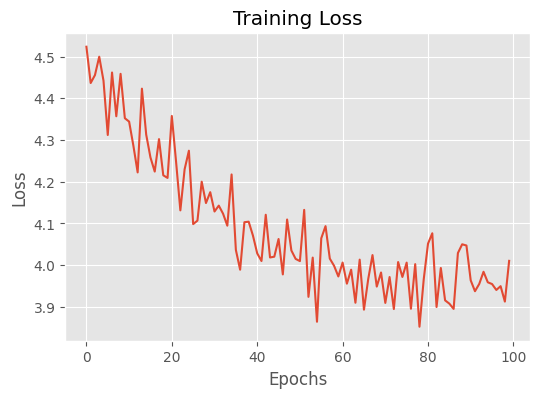

In [73]:
import matplotlib.pyplot as plt

# ggplot 스타일 적용
plt.style.use('ggplot')

logs = loss_logging_callback.logs
# loss_logging_callback에서 기록한 손실 값 가져오기
losses = [log['loss'] for log in logs if 'loss' in log] # 'loss' 키가 있는 로그만 추출

plt.figure(figsize=(6, 4))  # 배경색 설정
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


In [ ]:
save_directory = '../models/TinySolar-308m-4k-finetune'

pretrained_model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


('../models/TinySolar-308m-4k-finetune/tokenizer_config.json',
 '../models/TinySolar-308m-4k-finetune/special_tokens_map.json',
 '../models/TinySolar-308m-4k-finetune/tokenizer.model',
 '../models/TinySolar-308m-4k-finetune/added_tokens.json',
 '../models/TinySolar-308m-4k-finetune/tokenizer.json')

### Checking the performance of an intermediate checkpoint

Below, you can try generating text using an intermediate checkpoint of the model. This checkpoint was saved after 10,000 training steps. As you did in previous lessons, you'll use the Solar tokenizer and then set up a `TextStreater` object to display the text as it is generated: 

In [47]:
from transformers import AutoTokenizer, TextStreamer
model_name_or_path = "upstage/TinySolar-248m-4k"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

from transformers import AutoTokenizer, TextStreamer, AutoModelForCausalLM
import torch

model_name_or_path = "./output/checkpoint-10000"
model2 = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

prompt = "I am an engineer. I love"

inputs = tokenizer(prompt, return_tensors="pt").to(model2.device)

streamer = TextStreamer(
    tokenizer,
    skip_prompt=True,
    skip_special_tokens=True
)

outputs = model2.generate(
    **inputs,
    streamer=streamer,
    use_cache=True,
    max_new_tokens=64,
    do_sample=True,
    temperature=1.0,
)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


what I see in her heart that it is her own. I'm a strong woman, who likes your side of everything and is so happy to give a great contribution to the people.
If anyone has heard of your name, let him know you do indeed have a sister, but I'm not a member


# Lesson 6. Model evaluation

The model comparison tool that Sung described in the video can be found at this link: https://console.upstage.ai/ (note that you need to create a free account to try it out.)

A useful tool for evaluating LLMs is the **LM Evaluation Harness** built by EleutherAI. Information about the harness can be found at this [github repo](https://github.com/EleutherAI/lm-evaluation-harness):

You can run the commented code below to install the evaluation harness in your own environment:

```bash
#!pip install -U git+https://github.com/EleutherAI/lm-evaluation-harness
```

You will evaluate TinySolar-248m-4k on 5 questions from the **TruthfulQA MC2 task**. This is a multiple-choice question answering task that tests the model's ability to identify true statements. You can read more about the TruthfulQA benchmark in [this paper](https://arxiv.org/abs/2109.07958), and you can checkout the code for implementing the tasks at this [github repo](https://github.com/sylinrl/TruthfulQA).

The code below runs only the TruthfulQA MC2 task using the LM Evaluation Harness:

### Evaluation for the Hugging Face Leaderboard
You can use the code below to test your own model against the evaluations required for the [Hugging Face leaderboard](https://huggingface.co/open-llm-leaderboard). 

If you decide to run this evaluation on your own model, don't change the few-shot numbers below - they are set by the rules of the leaderboard.